In [1]:
!pip install --quiet tensorflow==2.7.0

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [3]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f'There are {num_users} total users and {num_items} total items')

There are 33901 total users and 126 total items


In [4]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # define user_embedding vector with num_users as input dimension, embedding size as output dimension
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        
        # define user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # define item_embedding vector with num_items as input dimension, embedding size as output dimension
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        
        # define item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           param inputs: user, item one-hot vectors
        """
        
        user_vector = self.user_embedding_layer(inputs[:, 0])  # compute user embedding vector
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])  # compute item embedding vector
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        x = dot_user_item + user_bias + item_bias  # add all components (including bias)
        
        return tf.nn.sigmoid(x)  # sigmoid layer to output probability

In [5]:
def process_dataset(raw_data):
    encoded_data = raw_data.copy()
    
    # map user IDs to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # map course IDs to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)  # convert original user IDs to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)  # convert original course IDs to idx
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")  # convert rating to int

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [6]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [7]:
def generate_train_test_datasets(dataset, scale=True):
    min_rating = min(dataset['rating'])
    max_rating = max(dataset['rating'])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[['user', 'item']].values

    if scale:
        y = dataset['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset['rating'].values

    # training on 80% of data, validating on 10%, testing on 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )

    return x_train, x_val, x_test, y_train, y_val, y_test

In [8]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [9]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [10]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [11]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

In [12]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

# compile model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# train model
history = model.fit(
    x=x_train, y=y_train,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/10
2917/2917 [==============================] - 11s 3ms/step - loss: 0.0721 - root_mean_squared_error: 0.2680 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1943
Epoch 2/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0338 - root_mean_squared_error: 0.1827 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1779
Epoch 3/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0289 - root_mean_squared_error: 0.1681 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1687
Epoch 4/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0270 - root_mean_squared_error: 0.1615 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1644
Epoch 5/10
2917/2917 [==============================] - 9s 3ms/step - loss: 0.0259 - root_mean_squared_error: 0.1576 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1614
Epoch 6/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0251 - root_mean_squared_error: 0.1548 - val_loss: 

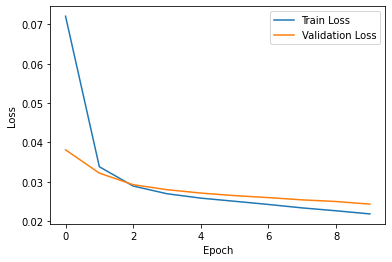

In [13]:
# plot train loss vs validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()